# Téléchargement des librairies

In [141]:
import pandas as pd
import numpy as np
import os

# ACP
import sklearn.decomposition as sd
import sklearn.preprocessing as sp

# Hierarchical clustering
import scipy.cluster.hierarchy as sch
#Wavelet
import pywt
from pywt import wavedec
from statsmodels.robust import mad
# LOF
import sklearn.neighbors as sn
# Isolation Forest
import sklearn.ensemble as se

# Plot et Display
from IPython.display import display
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()
sb.set_style("darkgrid", {"axes.facecolor": ".9"})

# Lecture des données

In [142]:
path="../Donnees_projet/Ensemble_apprentissage/"
#path="../Donnees_projet/Ensemble_test/"
files = os.listdir(path)
n=300 #nombre de vols dans l'ensemble de données

# Décomposition en ondelettes

In [183]:
wf = "haar"

Coeff = []
TCoeff = []

for i in range(n):
    data = pd.read_csv(path + files[i])
    x=data["FF_1"]
    #Apply wavelet decomposition
    coeffs = pywt.wavedec(x,wf,level=8)  #Niveau 8
    coeffs_flatten = np.hstack(coeffs)
    Coeff.append(coeffs_flatten)
    # Compute universal Threshold http://jseabold.net/blog/2012/02/23/wavelet-regression-in-python/
    sigma = mad(coeffs[-1])
    uthresh = sigma*np.sqrt(2*np.log(np.shape(x)))
    # Apply Threshold on 4 first levels
    coeffs_thresh = [pywt.threshold(c, uthresh, mode="hard") if i<=3 else c for i,c in enumerate(coeffs[::-1])]
    coeffs_thresh_flatten = np.hstack(coeffs_thresh[::-1])
    TCoeff.append(coeffs_thresh_flatten)
    
Coeff = np.array(Coeff)
TCoeff = np.array(TCoeff)
print(Coeff.shape, TCoeff.shape)
print(np.sum(Coeff!=0), np.sum(TCoeff!=0))

(300,) (300,)
1 1


/usr/local/insa/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


On pourra réaliser la décomposition en ondelettes seuillés avec les modes `hard`, `soft`, `greater` ou `less`.

# Analyse en composantes principales sur les coefficients d'ondelettes

## Choix des coefficients

On choisit de prendre les 300 premiers coefficients de chaque série.

In [188]:
#long_max = min([len(x) for x in Coeff])
long_max = 300

seuil = np.array([x[:long_max] for x in Coeff])
Tseuil = np.array([x[:long_max] for x in TCoeff])
print(seuil)

[[ 2.73920000e+04  2.67615000e+04  2.51280000e+04 ... -2.40000000e+01
  -1.60000000e+01  4.00000000e+00]
 [ 2.62515000e+04  2.72820000e+04  4.66100000e+04 ...  4.00000000e+00
   9.20000000e+01  1.16000000e+02]
 [ 2.56455000e+04  2.65000000e+04  2.56955000e+04 ...  4.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 2.95080000e+04  3.06845000e+04  4.20340000e+04 ... -1.64400000e+03
  -1.60000000e+03  0.00000000e+00]
 [ 2.54770000e+04  3.52195000e+04  2.64255000e+04 ...  1.20000000e+01
   8.00000000e+00  5.32000000e+02]
 [ 2.67425000e+04  3.65860000e+04 -2.55450000e+03 ... -5.65685425e+00
   0.00000000e+00  5.65685425e+00]]


On ne garde que les 30% (?) les plus important.

In [236]:
N=int(0.1*long_max) #30% coeffs les plus importants
seuil_30 = np.zeros((n,long_max))
Tseuil_30 = np.zeros((n,long_max))
for i in range(n):
    #seuil
    ind=np.argsort(seuil[i,:],axis=None)[::-1] #on trie du plus grand coeff au plus petit
    ind=ind[0:N] #on recupere les indices des 30% plus grands coeffs
    for j in range(long_max):
        if j in ind:
            seuil_30[i,j] = seuil[i,j] #on ne garde que les 30%
    #Tseuil  
    ind=np.argsort(Tseuil[i,:],axis=None)[::-1] #on trie du plus grand coeff au plus petit
    ind=ind[0:N] #on recupere les indices des 30% plus grands coeffs
    for j in range(long_max):
        if j in ind:
            Tseuil_30[i,j] = Tseuil[i,j] #on ne garde que les 30%
            
            
seuil=seuil_30
Tseuil=Tseuil_30

## ACP des coefficients d'ondelettes

In [237]:
acp = sd.PCA()
X_acp_ond = acp.fit_transform(sp.scale(seuil))

Text(0.5,1,'Distribution des premieres composantes')

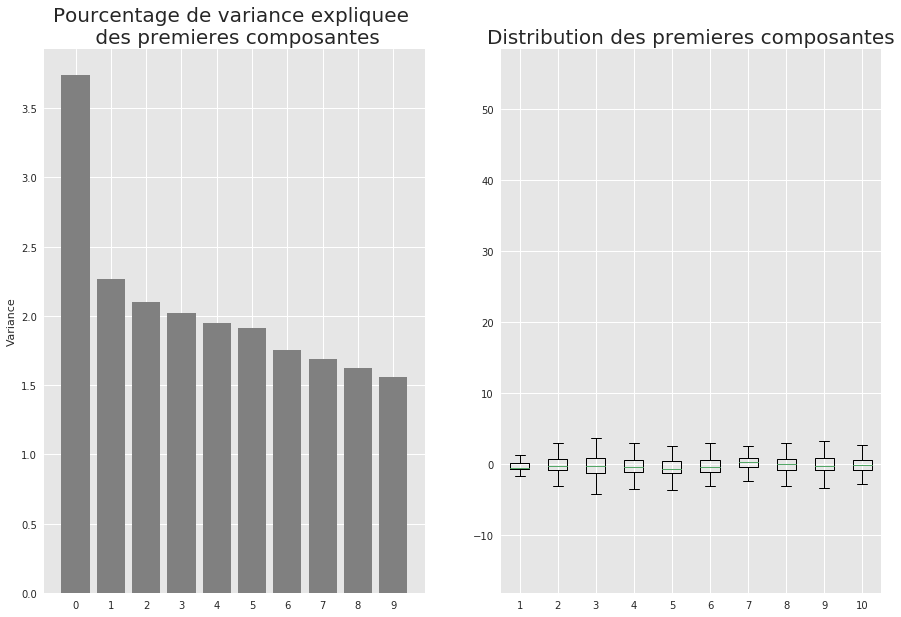

In [238]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,2,1)
ax.bar(range(10), acp.explained_variance_ratio_[:10]*100, align='center', color='grey', ecolor='black')
ax.set_xticks(range(10))
ax.set_ylabel("Variance")
ax.set_title("Pourcentage de variance expliquee \n des premieres composantes", fontsize=20)

ax = fig.add_subplot(1,2,2)
box=ax.boxplot(X_acp_ond[:,0:10])
ax.set_title("Distribution des premieres composantes", fontsize=20)


No handles with labels found to put in legend.


Text(0.5,1,'Projection des features sur les \n  deux premieres composantes')

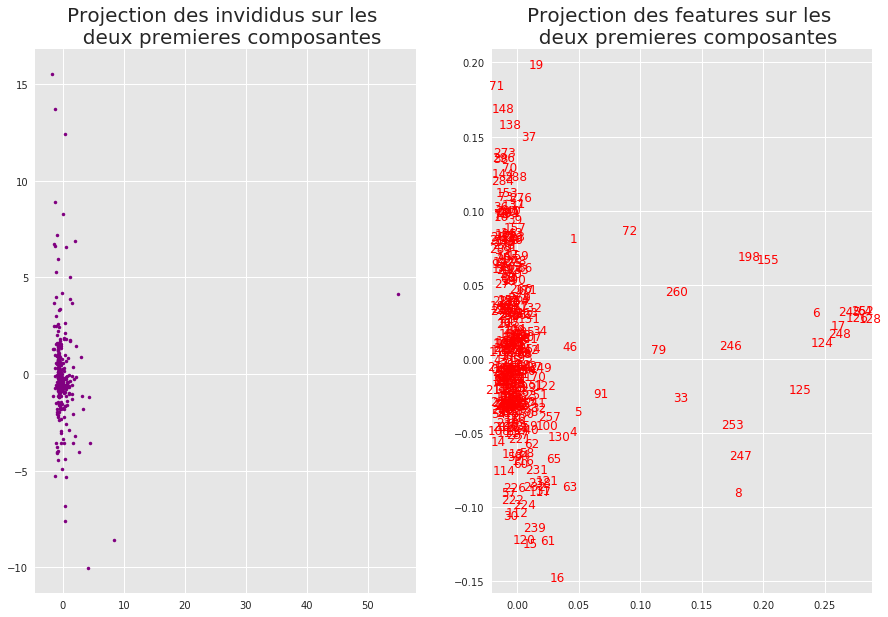

In [239]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,2,1)
for x,y,s in zip(X_acp_ond[:,0], X_acp_ond[:,1], map(str,range(n))):
    ax.plot(x,y,marker=".",color='purple')
plt.legend(fontsize=15)
ax.set_title("Projection des invididus sur les \n  deux premieres composantes", fontsize=20)


ax = fig.add_subplot(1,2,2)
for x,y,s in zip(acp.components_[0], acp.components_[1], map(str,range(n))):
    ax.text(x,y,s, horizontalalignment="center", verticalalignment="center", color="red")
ax.set_xlim(acp.components_[0].min()-0.002,acp.components_[0].max()+0.002)
ax.set_ylim(acp.components_[1].min()-0.01,acp.components_[1].max()+0.01)
ax.set_title("Projection des features sur les \n  deux premieres composantes", fontsize=20)


## Ondelettes de niveau le plus fin J=7 

In [240]:
#Coefficient de niveau 7 : 
Coeff7=seuil[:,128:]

In [241]:
acp = sd.PCA()
X_acp_ond7 = acp.fit_transform(sp.scale(Coeff7))

Text(0.5,1,'Distribution des premieres composantes')

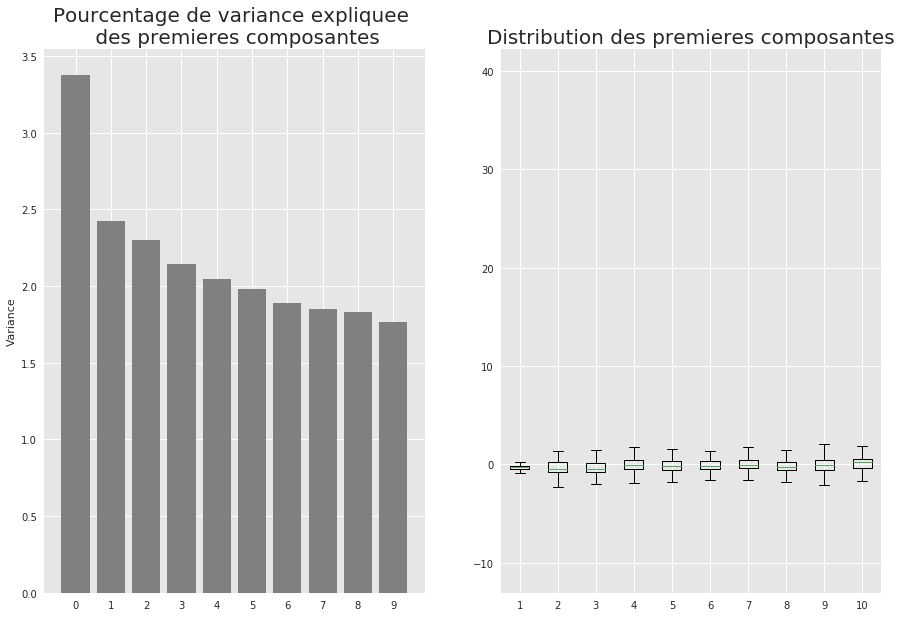

In [242]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,2,1)
ax.bar(range(10), acp.explained_variance_ratio_[:10]*100, align='center', color='grey', ecolor='black')
ax.set_xticks(range(10))
ax.set_ylabel("Variance")
ax.set_title("Pourcentage de variance expliquee \n des premieres composantes", fontsize=20)

ax = fig.add_subplot(1,2,2)
box=ax.boxplot(X_acp_ond7[:,0:10])
ax.set_title("Distribution des premieres composantes", fontsize=20)



No handles with labels found to put in legend.


Text(0.5,1,'Projection des features sur les \n  deux premieres composantes')

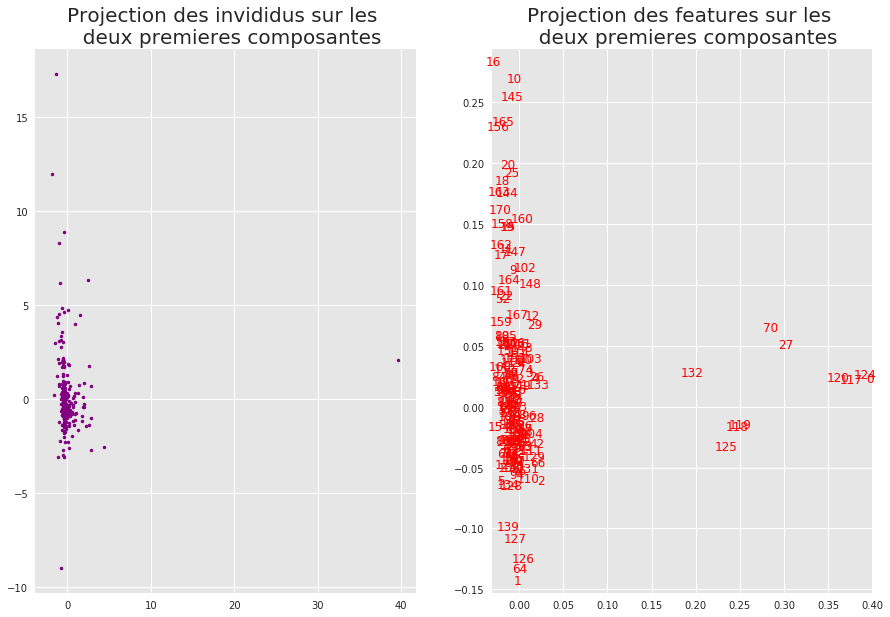

In [243]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,2,1)
for x,y,s in zip(X_acp_ond7[:,0], X_acp_ond7[:,1], map(str,range(n))):
    ax.plot(x,y,marker=".",color='purple')
plt.legend(fontsize=15)
ax.set_title("Projection des invididus sur les \n  deux premieres composantes", fontsize=20)


ax = fig.add_subplot(1,2,2)
for x,y,s in zip(acp.components_[0], acp.components_[1], map(str,range(n))):
    ax.text(x,y,s, horizontalalignment="center", verticalalignment="center", color="red")
ax.set_xlim(acp.components_[0].min()-0.002,acp.components_[0].max()+0.002)
ax.set_ylim(acp.components_[1].min()-0.01,acp.components_[1].max()+0.01)
ax.set_title("Projection des features sur les \n  deux premieres composantes", fontsize=20)

## ACP des coefficients d'ondelettes de niveau 1 à 6

In [244]:
#Coefficient de niveau 1 à 6 : 
CoeffA6=seuil[:,:128]

In [245]:
acp = sd.PCA()
X_acp_ondA6 = acp.fit_transform(sp.scale(CoeffA6))

Text(0.5,1,'Distribution des premieres composantes')

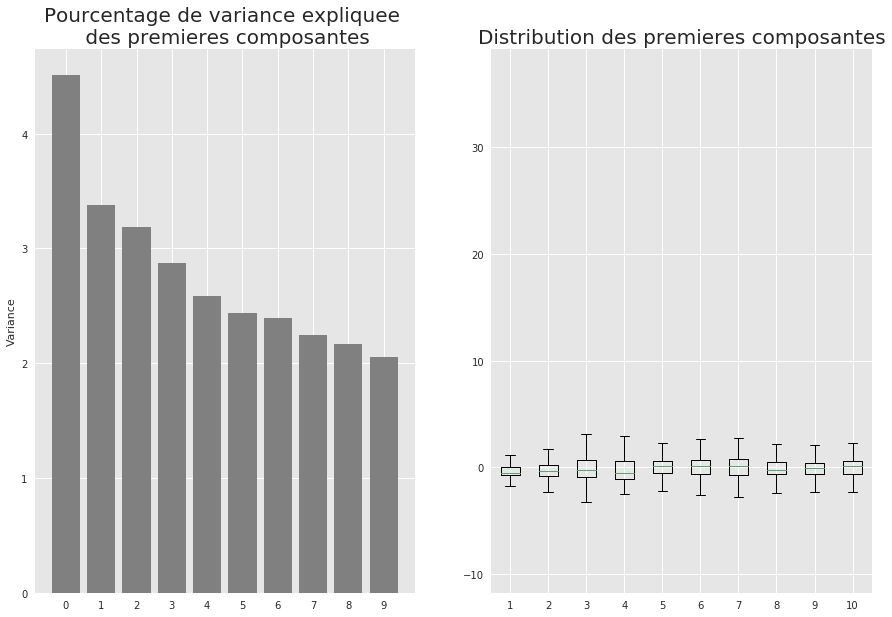

In [246]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,2,1)
ax.bar(range(10), acp.explained_variance_ratio_[:10]*100, align='center', color='grey', ecolor='black')
ax.set_xticks(range(10))
ax.set_ylabel("Variance")
ax.set_title("Pourcentage de variance expliquee \n des premieres composantes", fontsize=20)

ax = fig.add_subplot(1,2,2)
box=ax.boxplot(X_acp_ondA6[:,0:10])
ax.set_title("Distribution des premieres composantes", fontsize=20)


No handles with labels found to put in legend.


Text(0.5,1,'Projection des features sur les \n  deux premieres composantes')

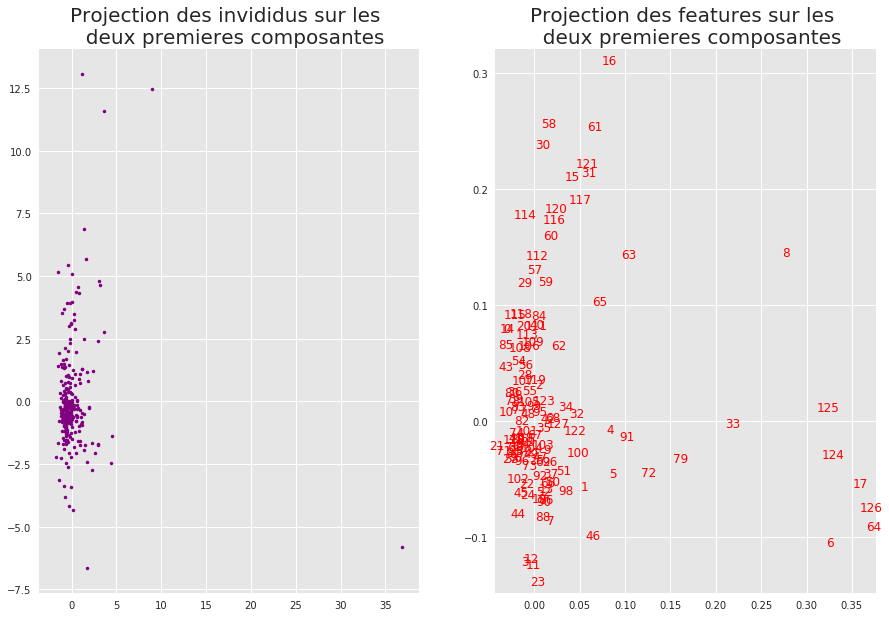

In [247]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,2,1)
for x,y,s in zip(X_acp_ondA6[:,0], X_acp_ondA6[:,1], map(str,range(n))):
    ax.plot(x,y,marker=".",color='purple')
plt.legend(fontsize=15)
ax.set_title("Projection des invididus sur les \n  deux premieres composantes", fontsize=20)


ax = fig.add_subplot(1,2,2)
for x,y,s in zip(acp.components_[0], acp.components_[1], map(str,range(n))):
    ax.text(x,y,s, horizontalalignment="center", verticalalignment="center", color="red")
ax.set_xlim(acp.components_[0].min()-0.002,acp.components_[0].max()+0.002)
ax.set_ylim(acp.components_[1].min()-0.01,acp.components_[1].max()+0.01)
ax.set_title("Projection des features sur les \n  deux premieres composantes", fontsize=20)


## ACP des coefficients d'ondelettes de niveau 1 à 4

In [248]:
#Coefficient de niveau 1 à 4 : 
CoeffA4=seuil[:,:16]

In [249]:
acp = sd.PCA()
X_acp_ondA4 = acp.fit_transform(sp.scale(CoeffA4))

Text(0.5,1,'Distribution des premieres composantes')

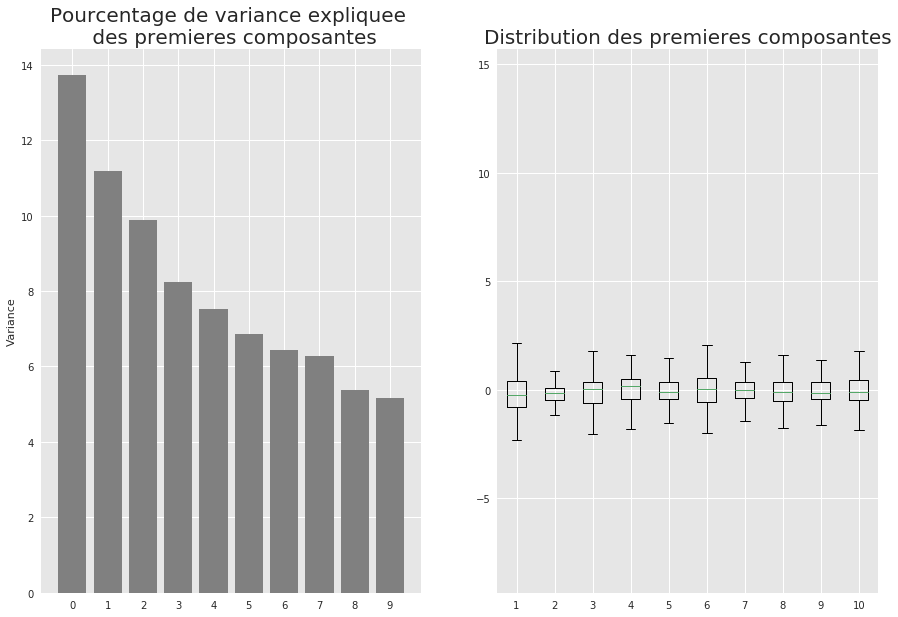

In [250]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,2,1)
ax.bar(range(10), acp.explained_variance_ratio_[:10]*100, align='center', color='grey', ecolor='black')
ax.set_xticks(range(10))
ax.set_ylabel("Variance")
ax.set_title("Pourcentage de variance expliquee \n des premieres composantes", fontsize=20)

ax = fig.add_subplot(1,2,2)
box=ax.boxplot(X_acp_ondA4[:,0:10])
ax.set_title("Distribution des premieres composantes", fontsize=20)


No handles with labels found to put in legend.


Text(0.5,1,'Projection des features sur les \n  deux premieres composantes')

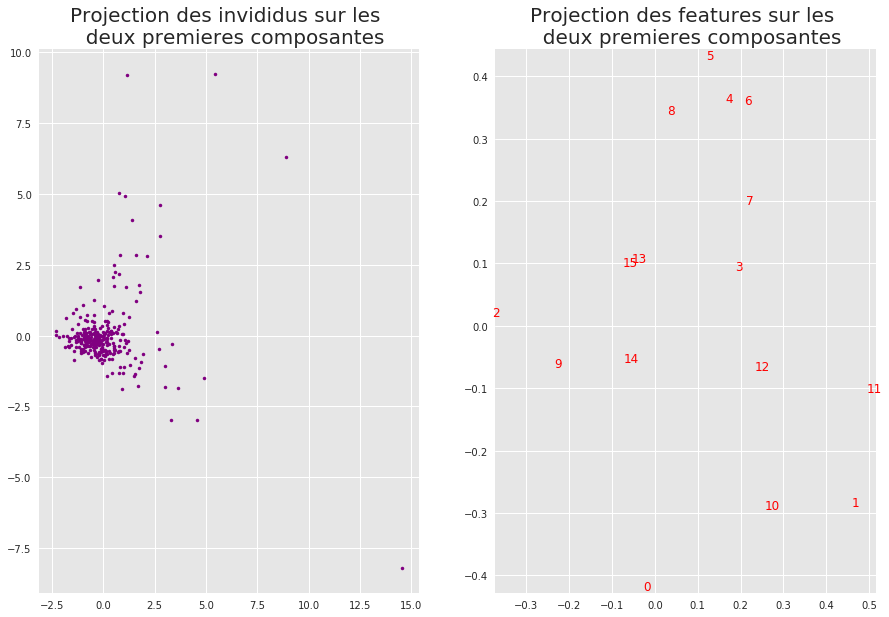

In [251]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,2,1)
for x,y,s in zip(X_acp_ondA4[:,0], X_acp_ondA4[:,1], map(str,range(n))):
    ax.plot(x,y,marker=".",color='purple')
plt.legend(fontsize=15)
ax.set_title("Projection des invididus sur les \n  deux premieres composantes", fontsize=20)


ax = fig.add_subplot(1,2,2)
for x,y,s in zip(acp.components_[0], acp.components_[1], map(str,range(n))):
    ax.text(x,y,s, horizontalalignment="center", verticalalignment="center", color="red")
ax.set_xlim(acp.components_[0].min()-0.002,acp.components_[0].max()+0.002)
ax.set_ylim(acp.components_[1].min()-0.01,acp.components_[1].max()+0.01)
ax.set_title("Projection des features sur les \n  deux premieres composantes", fontsize=20)

## ACP des coefficients d'ondelettes de niveau le plus fin J=4

In [256]:
#Coefficient de niveau 4 à 8 : 
Coeff4=seuil[:,16:]

In [258]:
acp = sd.PCA()
X_acp_ond4 = acp.fit_transform(sp.scale(Coeff4))

Text(0.5,1,'Distribution des premieres composantes')

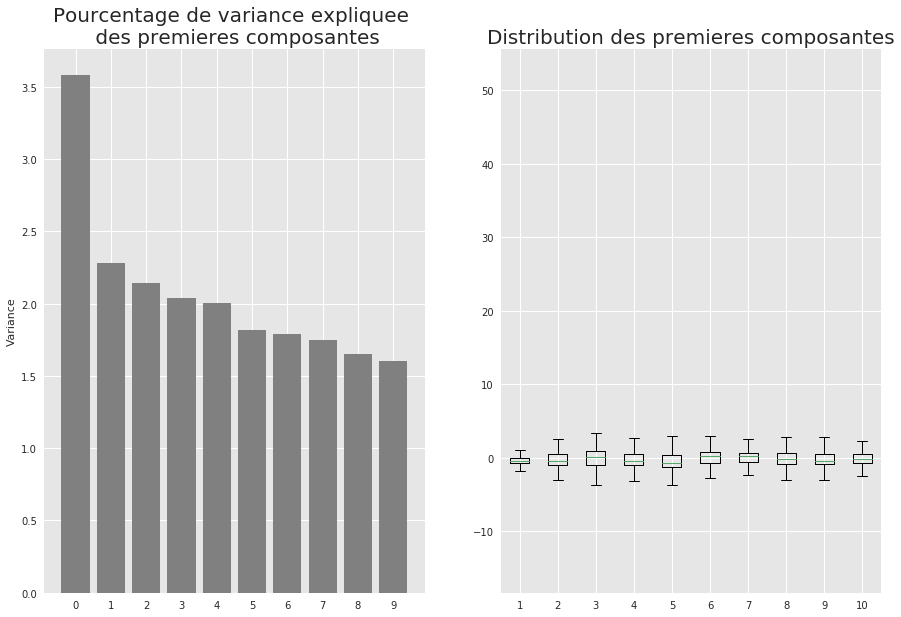

In [259]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,2,1)
ax.bar(range(10), acp.explained_variance_ratio_[:10]*100, align='center', color='grey', ecolor='black')
ax.set_xticks(range(10))
ax.set_ylabel("Variance")
ax.set_title("Pourcentage de variance expliquee \n des premieres composantes", fontsize=20)

ax = fig.add_subplot(1,2,2)
box=ax.boxplot(X_acp_ond4[:,0:10])
ax.set_title("Distribution des premieres composantes", fontsize=20)

No handles with labels found to put in legend.


Text(0.5,1,'Projection des features sur les \n  deux premieres composantes')

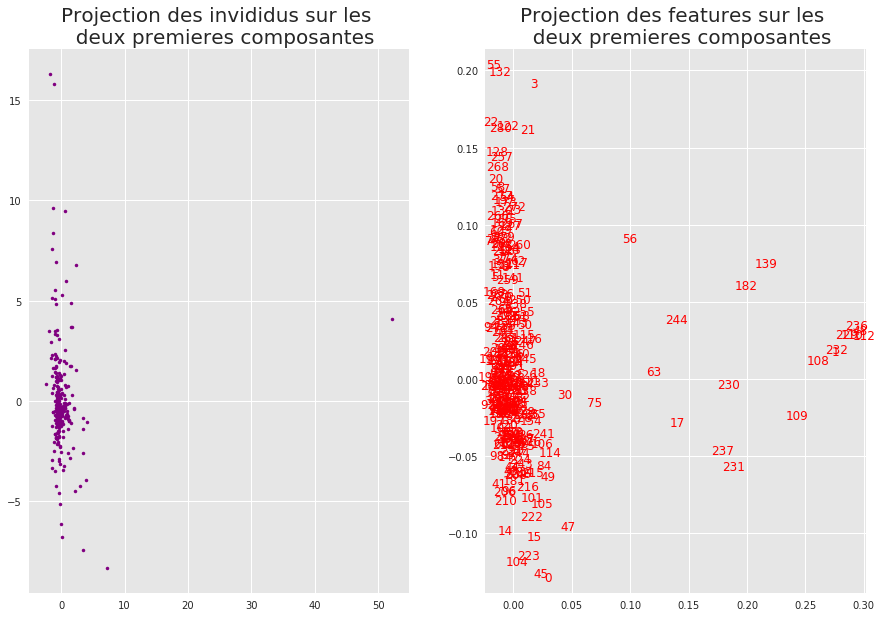

In [260]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,2,1)
for x,y,s in zip(X_acp_ond4[:,0], X_acp_ond4[:,1], map(str,range(n))):
    ax.plot(x,y,marker=".",color='purple')
plt.legend(fontsize=15)
ax.set_title("Projection des invididus sur les \n  deux premieres composantes", fontsize=20)


ax = fig.add_subplot(1,2,2)
for x,y,s in zip(acp.components_[0], acp.components_[1], map(str,range(n))):
    ax.text(x,y,s, horizontalalignment="center", verticalalignment="center", color="red")
ax.set_xlim(acp.components_[0].min()-0.002,acp.components_[0].max()+0.002)
ax.set_ylim(acp.components_[1].min()-0.01,acp.components_[1].max()+0.01)
ax.set_title("Projection des features sur les \n  deux premieres composantes", fontsize=20)

## ACP des coefficients seuillés

In [252]:
acp = sd.PCA()
X_acp_ondT = acp.fit_transform(sp.scale(Tseuil))

Text(0.5,1,'Distribution des premieres composantes')

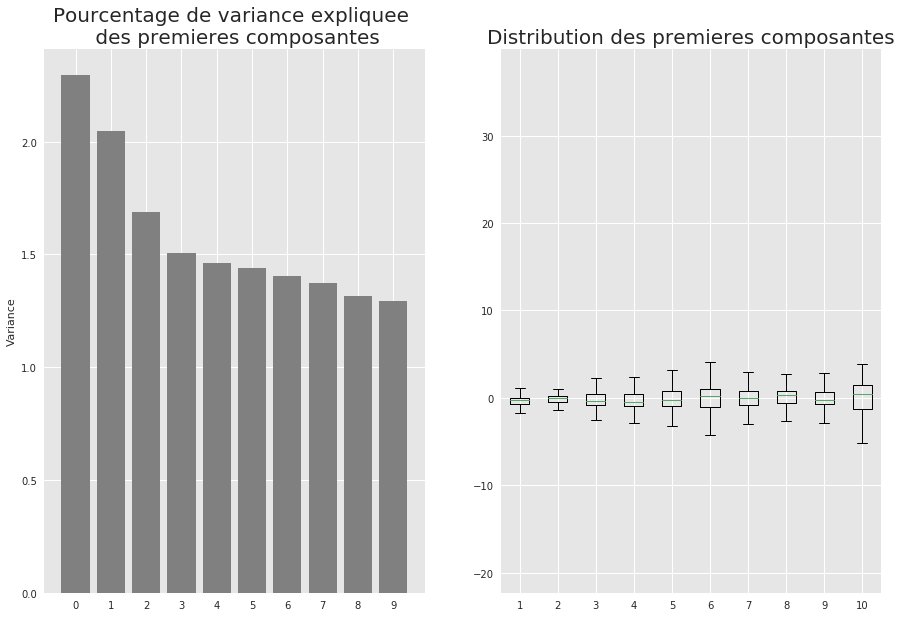

In [253]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,2,1)
ax.bar(range(10), acp.explained_variance_ratio_[:10]*100, align='center', color='grey', ecolor='black')
ax.set_xticks(range(10))
ax.set_ylabel("Variance")
ax.set_title("Pourcentage de variance expliquee \n des premieres composantes", fontsize=20)

ax = fig.add_subplot(1,2,2)
box=ax.boxplot(X_acp_ondT[:,0:10])
ax.set_title("Distribution des premieres composantes", fontsize=20)

No handles with labels found to put in legend.


Text(0.5,1,'Projection des features sur les \n  deux premieres composantes')

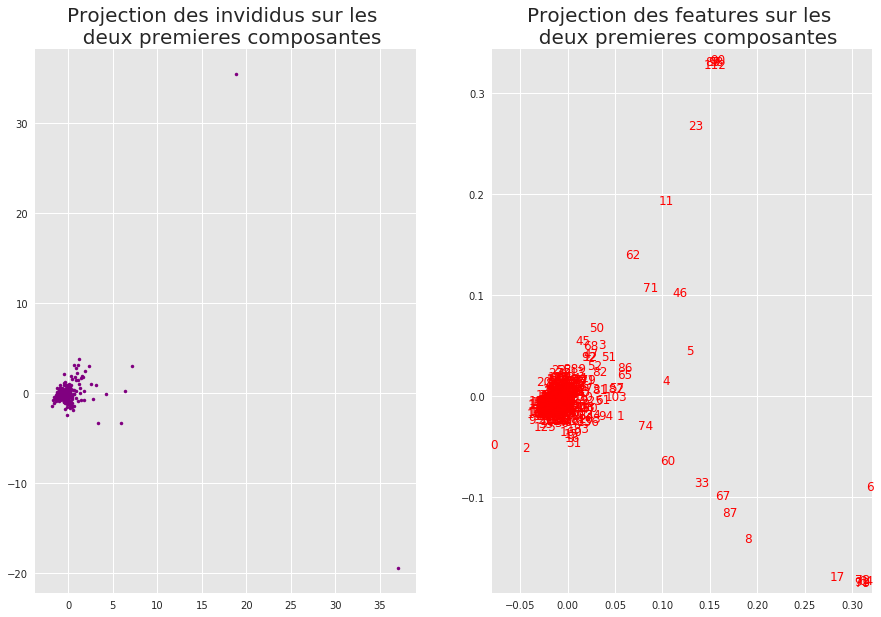

In [254]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,2,1)
for x,y,s in zip(X_acp_ondT[:,0], X_acp_ondT[:,1], map(str,range(n))):
    ax.plot(x,y,marker=".",color='purple')
plt.legend(fontsize=15)
ax.set_title("Projection des invididus sur les \n  deux premieres composantes", fontsize=20)


ax = fig.add_subplot(1,2,2)
for x,y,s in zip(acp.components_[0], acp.components_[1], map(str,range(n))):
    ax.text(x,y,s, horizontalalignment="center", verticalalignment="center", color="red")
ax.set_xlim(acp.components_[0].min()-0.002,acp.components_[0].max()+0.002)
ax.set_ylim(acp.components_[1].min()-0.01,acp.components_[1].max()+0.01)
ax.set_title("Projection des features sur les \n  deux premieres composantes", fontsize=20)

# Classicifation ascendante hierarchique

# Isolation Forest